In [1]:
import torch
import numpy as np
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import mediapipe as mp


device = 'cuda' if torch.cuda.is_available() else 'cpu'
# detector = MTCNN(image_size=224,device=device, post_process=False)


# MediaPipe

In [2]:
def get_fm_model() :
    mp_drawing = mp.solutions.drawing_utils
    point_drawing_spec = mp_drawing.DrawingSpec(thickness=4, circle_radius=1)
    line_drawing_spec = mp_drawing.DrawingSpec(thickness=4, color=[255,100,100])

    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        min_detection_confidence=0.5)

    fm = {'fm' : face_mesh, 'ds':mp_drawing }
    
    return fm


# Data preprocessing


In [12]:
def crop_left_eye(img, multi_face_landmarks, opened=False) :

    for face_landmark in multi_face_landmarks:
        le_left_x = int(face_landmark.landmark[130].x * img.shape[1])
        le_left_y = int(face_landmark.landmark[27].y * img.shape[0])
        le_right_x = int(face_landmark.landmark[243].x * img.shape[1])
        le_right_y = int(face_landmark.landmark[23].y * img.shape[0])

    
    cropped_eye = img[le_left_y:le_right_y, le_left_x:le_right_x]
    
    
        

#         img[le_left_y:le_right_y, le_left_x:le_right_x] = cv2.blur(cropped_eye, (20, 20))

        # draw landmark
#         fm['ds'].draw_landmarks(
#         image=img,
#         landmark_list=face_landmark,
#         connections=mp_face_mesh.FACE_CONNECTIONS,
#         landmark_drawing_spec=fm['ds'].DrawingSpec(thickness=4, circle_radius=1),
#         connection_drawing_spec=fm['ds'].DrawingSpec(thickness=4, color=[255,100,100]))
    if opened :
        return (le_left_x, le_left_y, le_right_x, le_right_y)
    else :
        return img, cropped_eye, (le_left_x, le_left_y, le_right_x, le_right_y)

In [13]:
def mediapipe_infer(img, fm, opened=False) :
    
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = fm['fm'].process(img)

    # Print and draw face mesh landmarks on the image.
    if not results.multi_face_landmarks:
        return img, img, None
    
    annotated_image = img.copy()
    face_landmark_coord = {'x':[], 'y':[], 'z':[]}
    color=[255,100,100]


    if opened :
        return crop_left_eye(annotated_image, results.multi_face_landmarks, opened)
    else :
        return crop_left_eye(annotated_image, results.multi_face_landmarks)
    


### Proprocessing Test

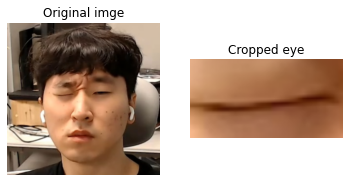

In [8]:
fm = get_fm_model()
img = cv2.imread('./aligned_data/closed/0004_01.png',cv2.IMREAD_COLOR)
annotated_image, cropped_eye, _ = mediapipe_infer(img, fm)
# annotated_image = mediapipe_infer(img, fm)
# print(face_landmark_coord)


fig = plt.figure()
rows = 1
cols = 2

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original imge')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.cvtColor(cropped_eye, cv2.COLOR_BGR2RGB))
ax2.set_title('Cropped eye')
ax2.axis("off")
 
plt.show()

# plt.imshow(annotated_image)
# cv2.imwrite('./cropped_eye.jpg', cropped_eye)

# Cropped eye Overlay to  open eye

In [15]:
def open_eye_overlay(o_eye_img, c_cropped_eye, coord) :

        le_left_x, le_left_y, le_right_x, le_right_y = coord[0], coord[1], coord[2], coord[3]

        c_cropped_eye = cv2.resize(c_cropped_eye, (le_right_x - le_left_x, le_right_y - le_left_y))
        o_eye_img[le_left_y:le_right_y, le_left_x:le_right_x] = c_cropped_eye
        
        return o_eye_img
    

In [17]:
from tqdm import tqdm
closed_eye_path = './aligned_data/closed'
opened_eye_path = './aligned_data/opened'

fm = get_fm_model()

c_img_names = os.listdir(closed_eye_path)
o_img_names = os.listdir(opened_eye_path)

index_norm = len(c_img_names) / len(o_img_names)

c_cropped_image = []
c_cropped_coord = []
for img_name in tqdm(c_img_names) :
    img_path = os.path.join(closed_eye_path, img_name)
    
    img = cv2.imread(img_path)
    
    _, cropped_image, cropped_coord = mediapipe_infer(img,fm)
    if cropped_coord is None : 
        continue
    c_cropped_image.append(cropped_image)    
    c_cropped_coord.append(cropped_coord)


o_cropped_img_name = []
o_cropped_coord = []
overlay_imgs = []
for idx, img_name in enumerate(tqdm(o_img_names)) :
    img_path = os.path.join(opened_eye_path, img_name)
    
    img = cv2.imread(img_path)
    
    coord = mediapipe_infer(img,fm,opened=True)
    overlay_img = open_eye_overlay(img, c_cropped_image[round(idx * index_norm) - 1], coord)
    
    o_cropped_img_name.append(img_path)
    o_cropped_coord.append(shape)
    overlay_imgs.append(overlay_img)


print(len(overlay_imgs))

100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [00:10<00:00, 30.76it/s]

333


## SAVE overlay img

In [ ]:
for idx, img in enumerate(overlay_imgs) :
    cv2.imwrite('./result/'+str(idx)+'.jpg', img)

# Read and Write Video 

In [25]:
def video_infer(video_path, output_path) :
    cap = cv2.VideoCapture(video_path)

    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    w = round(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_cnt = round(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)



    out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

    cnt = 1
    while True :

        ret, frame = cap.read()

        if ret :
            print(f"Complete [{cnt} / {frame_cnt}] {frame.shape}",end="\r")
            cnt += 1

            landmark, cropped_eye = mediapipe_infer(frame, fm)

            if landmark is None : 
                out.write(frame)
                continue

            out.write(landmark)

        else:
            break

    cap.release()
    out.release()


In [26]:
video_path = "test2.mp4"
output_path = "kernel_20_output.avi"

video_infer(video_path, output_path)

## Face Detector 성능

### MTCNN
    - 옆 모습 잘 못찾음
    - 정확도가 너무 떨어짐
    - 삭제함
    
### MediaPipe
    - 일단 성능은 보장됨.
    - mediapipe로 multi face landmark 가능한지 확인하기 -> 싱글 페이스 먼저 ㄱㄱ
    - detection 능력 너무 떨어짐.
    - 일정 거리 이상되면 얼굴 못찾음
    - 일단 단거리 & 싱글페이스 먼저 
    - face_landmark 좌표 가져온것 & opencv로 얼굴에 직접 찍어보기 -> 완료

### 윙크 만들기
    1. 눈 감은 상태를 덮어 씌운다. -> 제일 쉬운 방법
    2. 눈꺼풀 픽셀 값으로 눈동자를 채운다. -> 어려움 생각이 많이 필요할 듯 근데 만들면 의미 있을듯
    3. GAN 이용해서 눈을 새로 그려준다 -> 눈동자 픽셀 그리는 것보다 좋을 듯
    

# 코드 세이브